In [34]:
import glob
import os
import datetime as dt
import warnings
from pathlib import Path

from pyxlma import coords
from pyxlma.lmalib import lma_intercept_rhi
from pyxlma.lmalib.io import read as lma_read
from pyxlma.lmalib.flash.cluster import cluster_flashes
from pyxlma.lmalib.flash.properties import flash_stats, filter_flashes
from pyxlma.plot.xlma_plot_feature import plot_2d_network_points, plot_glm_events, plot_points, color_by_time
from pyxlma.plot.interactive import InteractiveLMAPlot
from pyxlma.lmalib.io.glm import combine_glm_l2

from glmtools.io.glm import GLMDataset

from cartopy import crs as ccrs
from cartopy import feature as cfeat
from ipywidgets import interact, widgets
from matplotlib import pyplot as plt
from matplotlib.dates import num2date
import numpy as np
import pandas as pd

%matplotlib widget
warnings.filterwarnings('ignore')

In [2]:
# Need to install goes2go for GLM data access; conda install -c conda-forge goes2go in this notebook's environment
from goes2go import GOES

## Set up the case time range of interest

In [3]:
# first_time = dt.datetime(2024,6,1,2,0,0)
# last_time = dt.datetime(2024,6,1,4,0,0)

first_time = dt.datetime(2024,6,1,3,40,0)
last_time = dt.datetime(2024,6,1,4,0,0)

print(first_time, "to", last_time, 
      "... Julian day is:", first_time.strftime("%j"), "to", last_time.strftime("%j"))

2024-06-01 03:40:00 to 2024-06-01 04:00:00 ... Julian day is: 153 to 153


## Some locations of interest

Add to this list to add them to the interactive plot.

In [4]:
radiometer_lat, radiometer_lon =  33.610066, -102.049599
tower200_lat, tower200_lon =  33.610559, -102.050564
KLBB_lat, KLBB_lon, KLBB_alt =  33.654139, -101.814167, 1005.0

station_lons = [radiometer_lon, tower200_lon, KLBB_lon]
station_lats = [radiometer_lat, tower200_lat, KLBB_lat]
station_labels = ['Radiometer', '200m', 'KLBB']

## Rough lon, lat bounds for the case

Set up a lat lon box which data loading can use to filter points if it so chooses.

In [15]:
# It's about 110 km per degree of latitude
lon_span = KLBB_lon - 2.0, KLBB_lon + 2.0
lat_span = KLBB_lat - 2.0, KLBB_lat + 2.0

## Download WTLMA data

We will manually construct the URLs from the WTLMA THREDDS server, which follow a nice pattern, and then download them automatically.

In the cell below, give a path where you want to save the LMA data, and the start and end time of the analysis period of interest.

In [6]:
lma_data_dir = Path('./LMA/')
lma_data_dir.mkdir(parents=True, exist_ok=True)

In [7]:
import urllib.request
from datetime import datetime, timedelta

sec_per_lma_file = 600
file_time_step = dt.timedelta(0, sec_per_lma_file)
n_files = (last_time-first_time)/file_time_step

base_url = f"http://pogo.tosm.ttu.edu/thredds/fileServer/processedData/%Y/%b/%d/WTLMA_2011_%y%m%d_%H%M%S_{sec_per_lma_file:04d}.dat.gz"

all_times = (first_time + file_time_step*i for i in range(int(n_files)))
urls = [t.strftime(base_url) for t in all_times]
lma_files = [lma_data_dir.joinpath(url.split('/')[-1]) for url in urls]
for url, lma_file in zip(urls, lma_files):
    if lma_file.exists():
        print("Already have", lma_file)
    else:
        print("Downloading", lma_file)
        urllib.request.urlretrieve(url, lma_file)

Already have LMA/WTLMA_2011_240601_034000_0600.dat.gz
Already have LMA/WTLMA_2011_240601_035000_0600.dat.gz


## Download GLM data

In [8]:
glm_data_dir = Path('./GLM/')
glm_data_dir.mkdir(parents=True, exist_ok=True)

In [9]:
GLM16 = GOES(satellite=16, product="GLM-L2-LCFA")#, domain='C')
GLM18 = GOES(satellite=18, product="GLM-L2-LCFA")#, domain='C')

# Do the download. goes2go manages the cache
glm16_df = GLM16.timerange(first_time, last_time, save_dir=str(glm_data_dir.absolute()), verbose=False)
glm18_df = GLM18.timerange(first_time, last_time, save_dir=str(glm_data_dir.absolute()), verbose=False)

domain argument is ignored for non-ABI products
domain argument is ignored for non-ABI products


📦 Finished downloading [60] files to [/Users/ebruning/code/lmaworkshop/WTLMA/GLM/noaa-goes16/GLM-L2-LCFA].
📦 Finished downloading [60] files to [/Users/ebruning/code/lmaworkshop/WTLMA/GLM/noaa-goes18/GLM-L2-LCFA].


In [10]:
glm16_fns = [glm_data_dir.joinpath(str(fn)) for fn in glm16_df.file]
glm18_fns = [glm_data_dir.joinpath(str(fn)) for fn in glm18_df.file]

In [11]:
glm16_ds = combine_glm_l2(glm16_fns)

In [13]:
glm18_ds = combine_glm_l2(glm18_fns)

In [19]:
glm16_obj = GLMDataset(glm16_ds, check_area_units=False, change_energy_units=False)
glm18_obj = GLMDataset(glm18_ds, check_area_units=False, change_energy_units=False)

In [22]:
# Load only the flashes that are relatively close to the center of the network.
glm16_sub = glm16_obj.subset_flashes(lon_range=lon_span, lat_range=lat_span)
glm18_sub = glm16_obj.subset_flashes(lon_range=lon_span, lat_range=lat_span)

## ENTLN data path

In [26]:
entln_csv = 'unknown.csv'
read_entln = False

# Creating a cross section through a RHI scan

In field campaigns with radar systems performing vertical, range-height indicator scans, we can visualize a cross section of LMA points along the plane of the RHI.

# Read in data

Read in ENTLN csv file and lma .dat.gz (Note: this is not actual ENTLN data, but the csv file included takes the same format of real ENTLN data)

If you ran the previous tutorial, it is possible to read in the netcdf file without having to re-cluster the flashes and re-calculate flash stats.

In [30]:
if read_entln:
    entln_data = lma_read.entln()
    # Assign a height AGL of 500m for all CGs so that they show up on plots with a 0 y minimum
    entln_data['icheight'] = np.where(entln_data['type'] == 'CG', 500, entln_data['icheight'])

In [31]:
filenames = [str(lma_file) for lma_file in lma_files]
lma_data, start_time = lma_read.dataset(filenames)
print("Read all LMA files")

# Filter events
min_event_stations = 6
max_event_chi2 = 1
good_events = (lma_data.event_stations >= min_event_stations) & (lma_data.event_chi2 <= max_event_chi2)
lma_data = lma_data[{'number_of_events':good_events}]

print("Clustering and filtering flashes")
# Cluster flashes and calculate stats
lma_data = flash_stats(cluster_flashes(lma_data))
# Filter Flashes
min_points_per_flash = 5
big_flash_data = filter_flashes(lma_data, flash_event_count=(min_points_per_flash, None))
big_flash_data

Read all LMA files
Clustering and filtering flashes


<xarray.Dataset> Size: 60MB
Dimensions:                              (number_of_stations: 13,
                                          number_of_events: 718445,
                                          number_of_flashes: 10363)
Coordinates:
  * number_of_flashes                    (number_of_flashes) uint64 83kB 0 .....
Dimensions without coordinates: number_of_stations, number_of_events
Data variables: (12/42)
    network_center_latitude              float64 8B 33.61
    network_center_longitude             float64 8B -101.8
    network_center_altitude              float64 8B 984.0
    station_latitude                     (number_of_stations) float32 52B 33....
    station_longitude                    (number_of_stations) float32 52B -10...
    station_altitude                     (number_of_stations) float32 52B 984...
    ...                                   ...
    flash_event_count                    (number_of_flashes) uint32 41kB 196 ...
    event_parent_flash_id                (number_of_events) uint64 6MB 0 ... ...
    event_x                              (number_of_events) float64 6MB 3.741...
    event_y                              (number_of_events) float64 6MB -2.15...
    event_z                              (number_of_events) float32 3MB 9.359...
    flash_id                             (number_of_flashes) uint64 83kB 0 .....
Attributes:
    flash_algorithm_version:  0.1
    production_date:          2025-01-04 22:51:45 +00:00
    comment:                  
    flash_algorithm_name:     pyxlma DBSCAN
    event_algorithm_version:   10.14.9R
    institution:              unknown
    production_site:          Default
    history:                  LMA source file created  Fri Aug 30 15:24:38 20...
    references:               
    title:                    Lightning Mapping Array Dataset, L1b events and...
    source:                   VHF Lightning Mapping Array
    event_algorithm_name:      /data/lma_realtime/new/lma_analysis-10.14.9R -...

In [36]:
class AnnotatedLMAPlot(InteractiveLMAPlot):
    # @output.capture()
    def make_plot(self):
        # Use the built-in LMA functionality
        super(AnnotatedLMAPlot, self).make_plot()
        
        
        glm16_art = plot_glm_events(glm16_sub, self.lma_plot, fake_alt=[0, 0.25], 
                                    poly_kwargs={'cmap' : 'plasma_r', 'alpha':0.5, 'zorder':0}, 
                                    vlines_kwargs={'linewidths' : 0.5}, 
                                    should_parallax_correct=True)

        self.data_artists.extend(glm16_art)
        
        # Add our own title
        tlim = self.bounds['t']
        tlim_sub = pd.to_datetime(tlim[0]), pd.to_datetime(tlim[1])
        title = tlim_sub[0].strftime('%Y%m%d %H%M%S') + ' to ' + tlim_sub[1].strftime('%Y%m%d %H%M%S') + ' UTC'
        self.lma_plot.ax_th.set_title(title)
                
        # Add the station positions we defined above, and label them. We only need to add them to the plan-view plot.
        # The other axes are self.lma_plot.ax_th, .ax_lon, and .ax_lat.
        new_artists = []
        art = self.lma_plot.ax_plan.scatter(station_lons, station_lats, color='k', zorder=-10)
        new_artists.append(art)
        for slon,slat,slabel in zip(station_lons, station_lats, station_labels):
            txt_art = self.lma_plot.ax_plan.text(slon, slat, slabel)
            new_artists.append(txt_art)

        if read_entln:
            entln_art = plot_2d_network_points(self.lma_plot, entln_data, color_by='polarity', actual_height=entln_data['icheight']/1000)
            new_artists.extend(entln_art)
        self.data_artists.extend(new_artists)

# Find an interesting flash to compare to an RHI scan!

This example shows how ipywidgets can be used to interactively explore flashes one at a time.

I set this up to filter to Flash ID 64 when it first plots, because after scrolling around for a few minutes, that flash looks interesting to me to visualize as an RHI. 
(67 is also a good option, try it!)

You can turn off the "filter to flash ID"
checkbox to limit to any aribtrary range to plot later on.

The map is also interactive, try zooming in on the flashes to find an interesting one!

interactive(children=(Checkbox(value=False, description='Filter to Flash ID'), SelectionSlider(description='Fl…

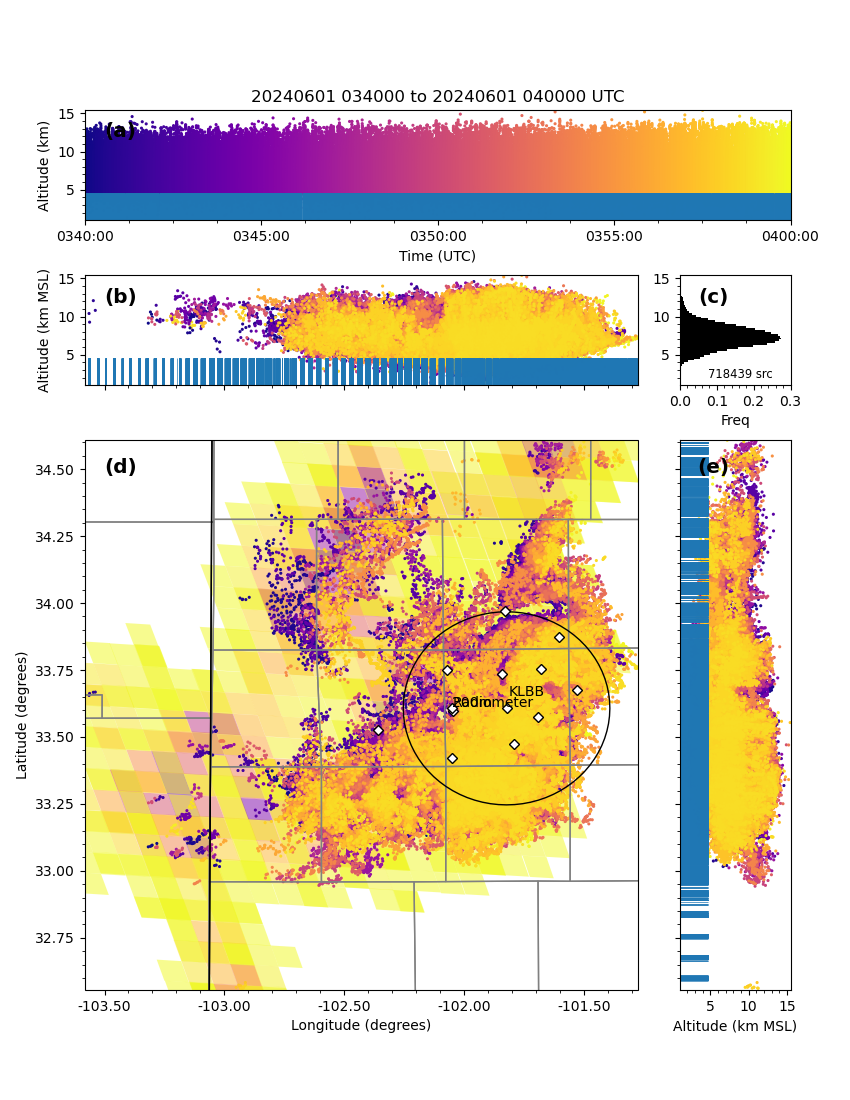

In [37]:
interact_lma = AnnotatedLMAPlot(big_flash_data, clon=big_flash_data.network_center_longitude,
                                  clat=big_flash_data.network_center_latitude, tlim=[first_time, last_time])    


def create_interact(use_flash_id=False, flash_id=0):
    if use_flash_id:
        this_flash = big_flash_data.sel(number_of_flashes=flash_id)
        flash_i_want = this_flash.flash_id.data.item()
        events_in_flash = (this_flash.event_parent_flash_id == flash_i_want)
        this_flash = this_flash[{'number_of_events':events_in_flash}]
        interact_lma.ds = this_flash
        flash_start_time = this_flash.flash_time_start.data.item()
        flash_end_time = this_flash.flash_time_end.data.item()
        interact_lma.bounds['t'] = [flash_start_time, flash_end_time]
    else:
        interact_lma.ds = big_flash_data
        t0, t1 = num2date(interact_lma.lma_plot.ax_th.get_xlim())
        interact_lma.bounds['t'] = (t0.replace(tzinfo=None), t1.replace(tzinfo=None))
    interact_lma.make_plot()
    interact_lma.make_plot_interactive()

use_flash_or_not = widgets.Checkbox(value=False, description='Filter to Flash ID')
flash_id_sel = widgets.SelectionSlider(options=big_flash_data.flash_id.data, description='Flash ID', value=64)
my_widgets = interact(create_interact, use_flash_id=use_flash_or_not, flash_id=flash_id_sel)

# Get the location and time of the points we selected

If you've selected a single flash, it's possible to use the `flash_center_latitude`, `flash_center_longitude`, `flash_center_altitude`, and `flash_time_start`/`flash_time_end` variables without recalculating anything.
However, for an arbitrary range of points, the averages of these variables must be obtained to get the most representative radar scan.

In [13]:
selected_data = interact_lma.ds.copy()
center_lon = selected_data.event_longitude.mean(dim='number_of_events').data.item()
center_lat = selected_data.event_latitude.mean(dim='number_of_events').data.item()
center_alt = selected_data.event_altitude.mean(dim='number_of_events').data.item()

selected_time = selected_data.event_time.mean(dim='number_of_events')
# Convert that to a standard python datetime. This loses nanosecond precision, but allows the time to be used in nexradaws
selected_time = selected_time.data.astype('datetime64[us]').astype(dt.datetime).item()
print(selected_time)

2022-11-20 10:13:53.474733


In [14]:
import nexradaws
conn = nexradaws.NexradAwsInterface()
radar_id = 'KTYX'

range_start = selected_time - dt.timedelta(minutes=5)
range_end = selected_time + dt.timedelta(minutes=5)

scans = conn.get_avail_scans_in_range(range_start, range_end, radar_id)
scans = [scan for scan in scans if 'MDM' not in scan.filename]
print(scans)

[<AwsNexradFile object - 2022/11/20/KTYX/KTYX20221120_101106_V06>, <AwsNexradFile object - 2022/11/20/KTYX/KTYX20221120_101710_V06>]


The radar scan closest to our flash took place at 09:52:49 UTC. Download that one.

In [15]:
radar_download = conn.download(scans[-1], '.')

Downloaded KTYX20221120_101710_V06
1 out of 1 files downloaded...0 errors


In [16]:
import pyart
import cmweather
radar_file_path = radar_download.success[0].filepath # try changing this to a string with the path to your own data!
radar = pyart.io.read(radar_file_path)
print(list(radar.fields.keys()))

['spectrum_width', 'differential_reflectivity', 'velocity', 'cross_correlation_ratio', 'reflectivity', 'differential_phase', 'clutter_filter_power_removed']


Now, create a map of the reflectivity with the LMA points!

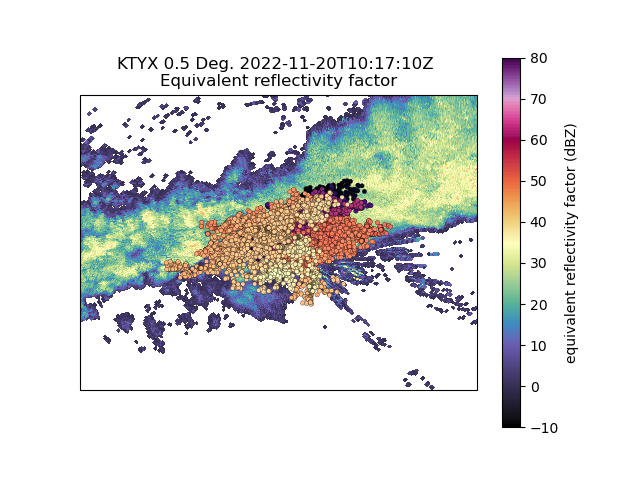

In [17]:
field_i_want = 'reflectivity'
radar_fig = plt.figure()
radar_ax = plt.axes(projection=ccrs.PlateCarree())

rmd = pyart.graph.RadarMapDisplay(radar)
# Here I mask out reflectivities below 0 dBZ to get rid of some of the ground clutter.
rmd.plot_ppi_map(field_i_want, mask_tuple=('reflectivity', 0), vmin=-10, vmax=80, cmap='ChaseSpectral', ax=radar_ax, fig=radar_fig, add_grid_lines=False)

radar_ax.scatter(selected_data.event_longitude, selected_data.event_latitude, c=selected_data.event_time, cmap='magma', s=10, edgecolor='k', linewidths=0.2, transform=ccrs.PlateCarree())
radar_ax.set_extent([selected_data.event_longitude.data.min()-0.25, selected_data.event_longitude.data.max()+0.25,
                   selected_data.event_latitude.data.min()-0.25, selected_data.event_latitude.data.max()+0.25])

Using the flash_center variables, find the azimuth of the flash from the perspective of the radar to build a psuedo-RHI from

In [18]:
radar_lon = radar.longitude['data'][0]
radar_lat = radar.latitude['data'][0]
radar_alt = radar.altitude['data'][0]
radar_time = pyart.util.datetime_from_radar(radar)

plate_carree_projection = coords.GeographicSystem()
radar_coords = coords.RadarCoordinateSystem(radar_lat, radar_lon, radar_alt)

selected_data.flash_center_longitude.data, selected_data.flash_center_latitude.data, selected_data.flash_center_altitude.data
flash_range, flash_azimuth, flash_elevation = radar_coords.fromECEF(*plate_carree_projection.toECEF(selected_data.flash_center_longitude.data, selected_data.flash_center_latitude.data, selected_data.flash_center_altitude.data))
flash_range = flash_range[0]
flash_azimuth = flash_azimuth[0]
flash_elevation = flash_elevation[0]
print(f'Flash center is located at azimuth {flash_azimuth:.1f}°, elevation of {flash_elevation:.1f}°, and range of {flash_range:.1f}m')

Flash center is located at azimuth 341.4°, elevation of 11.1°, and range of 13004.1m


Make an RHI plot of the nearest azimuth to the flash centroid

(0.0, 10.0)

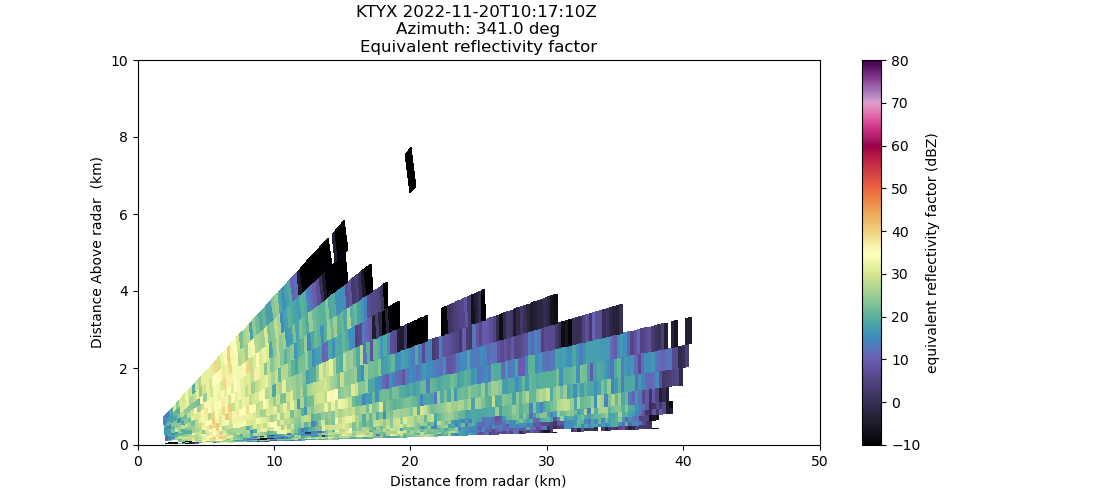

In [19]:
rhi_fig = plt.figure(figsize=(11, 5))
rhi_ax = rhi_fig.gca()
rmd.plot_azimuth_to_rhi(field_i_want, int(flash_azimuth), vmin=-10, vmax=80, cmap='ChaseSpectral', ax=rhi_ax, fig=rhi_fig)
rhi_ax.set_xlim([0, 50])
rhi_ax.set_ylim([0, 10])

Transform the LMA points from lat/lon/altitude to range along the RHI plane, distance from the plane, and height above the radar. Add these transformed points to the above figure. If the LMA data were not already filtered to a single flash, the `distance_threshold` keyword argument could be used to filter to sources that are close (spatially) to the RHI plane, and the `time_threshold` could be used to filter to sources that are close temporally. Since the LMA data is already filtered to a single flash that is close to the RHI time, and the RHI goes through the center of the flash, set these to None to disable this filtering.

In [20]:
lma_range, lma_distance, lma_ARL, point_mask = lma_intercept_rhi.find_lma_points_near_rhi(selected_data, radar_lat, radar_lon, radar_alt, int(flash_azimuth), radar_time, distance_threshold=None, time_threshold=None)
sec_since_flash_start = (selected_data.event_time[point_mask] - np.min(selected_data.flash_time_start.data)).astype(float)/1e6
pcm = rhi_ax.scatter(lma_range/1000, lma_ARL/1000, c=sec_since_flash_start, cmap='magma', s=10, edgecolor='k', linewidths=0.2)
rhi_fig.colorbar(pcm, label='Time since flash initiation (ms)')

Add ENTLN data along the ground for LMA verification

In [21]:
negative_cg_range, negative_cg_distance, negative_cg_ARL, negative_cg_mask = lma_intercept_rhi.find_points_near_rhi(
    entln_data['longitude'], entln_data['latitude'], np.zeros_like(entln_data['longitude']), entln_data['datetime'],
    radar_lat, radar_lon, radar_alt, int(flash_azimuth), radar_time, distance_threshold=None, time_threshold=None)


rhi_ax.scatter(negative_cg_range/1000, entln_data['icheight']/1000, c='blue', marker='X')